In [1]:
import graph_search_algorithm_compilation
import matplotlib.pyplot as plt
import networkx as nx
import random
import time

# from joblib import Parallel, delayed
from tqdm import tqdm
from dask.distributed import Client
from dask import delayed, compute

In [2]:
if 'client' in globals():
    client.close()
client = Client()

/opt/conda/lib/python3.11/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 35113 instead
  warnings.warn(


In [3]:
# Generate a random weighted graph for the simulation
def generate_random_graph(num_nodes, prob=0.1, max_weight=10):
    G = nx.gnp_random_graph(num_nodes, prob, directed=False)
    for (u, v) in G.edges():
        G.edges[u, v]['weight'] = random.randint(1, max_weight)
    return G

In [4]:
# Apply flood conditions to the graph
def apply_flood_conditions(G, flood_probability):
    flooded_edges = []
    for u, v in G.edges():
        if random.random() < flood_probability:
            flooded_edges.append((u, v))
            G.remove_edge(u, v)  # Remove the flooded edges from the graph
    return G

In [5]:
algorithms = {
    "Dijkstra": graph_search_algorithm_compilation.dijkstra_search,
    "Floyd-Warshall": graph_search_algorithm_compilation.floyd_warshall_search,
    "Bellman-Ford": graph_search_algorithm_compilation.bellman_ford_search,
    "Bidirectional": graph_search_algorithm_compilation.bidirectional_search,
    "Dynamic": graph_search_algorithm_compilation.dynamic_shortest_path,
    # "D* Lite": graph_search_algorithm_compilation.d_star_lite,
    "A* Search": graph_search_algorithm_compilation.a_star_search,
    # "MCTS": graph_search_algorithm_compilation.monte_carlo_tree_search,
    "Yen's K-Shortest Paths": graph_search_algorithm_compilation.yen_k_shortest_paths,
    # "ACO": graph_search_algorithm_compilation.ant_colony_optimization,
}

In [6]:
# # Function to evaluate algorithm performance in each iteration
# def evaluate_algorithm(algorithm_func, G, source, target):
#     start_time = time.time()
#     try:
#         # Call the algorithm with (G, source, target, weight)
#         path = algorithm_func(G, source, target, weight='weight')
#         duration = time.time() - start_time
#         # If no path is found, return infinite cost and an empty list for the path
#         if path is None or len(path) == 0:
#             return float('inf'), []  # Infinite cost for no path found
#         return duration, path  # Return computation time and the path
#     except Exception as e:
#         return float('inf'), []  # Infinite cost for any errors


# # Parallel execution using joblib
# def run_in_parallel(algorithms, G, source, target):
#     results = Parallel(n_jobs=-1)(delayed(evaluate_algorithm)(algo_func, G.copy(), source, target)
#                                   for algo_func in algorithms.values())
#     return results


# # Monte Carlo Simulation: Run all algorithms in parallel on the same graph
# def monte_carlo_simulation(num_iterations, graph_size, flood_probability):
#     algorithm_performance = {name: [] for name in algorithms.keys()}  # Track performance for each algorithm

#     # Generate the graph and apply flood conditions once
#     G = generate_random_graph(graph_size)
#     while not nx.is_connected(G):
#         G = generate_random_graph(graph_size)
#     G = apply_flood_conditions(G, flood_probability)

#     source = random.choice(list(G.nodes()))
#     target = random.choice(list(G.nodes()))

#     # Ensure source and target are not the same
#     while source == target:
#         target = random.choice(list(G.nodes()))

#     # Step 4: Evaluate all algorithms in parallel over the same graph, flooded conditions, and source/target
#     for _ in range(num_iterations):
#         results = run_in_parallel(algorithms, G, source, target)

#         # Store results in performance dictionary
#         for algo_name, result in zip(algorithms.keys(), results):
#             algorithm_performance[algo_name].append(result)

#     return algorithm_performance

In [7]:
# Parallel execution using Dask
@delayed
def evaluate_algorithm(algorithm_func, G, source, target):
    start_time = time.time()
    try:
        # Call the algorithm with (G, source, target, weight)
        path = algorithm_func(G, source, target, weight='weight')
        duration = time.time() - start_time
        if path is None:
            return float('inf'), []  # Infinite cost for no path found
        return duration, path  # Return computation time and the path
    except Exception as e:
        return float('inf'), []  # Infinite cost for errors


# Run algorithms in parallel using Dask
def run_in_parallel(algorithms, G, source, target):
    delayed_results = [evaluate_algorithm(algo_func, G.copy(), source, target) 
                       for algo_func in algorithms.values()]
    results = compute(*delayed_results)
    return results


# Monte Carlo Simulation: Run all algorithms in parallel on the same graph
def monte_carlo_simulation(num_iterations, graph_size, flood_probability):
    algorithm_performance = {name: [] for name in algorithms.keys()}  # Track performance for each algorithm

    # Generate the graph and apply flood conditions once
    G = generate_random_graph(graph_size)
    while not nx.is_connected(G):
        G = generate_random_graph(graph_size)
    G = apply_flood_conditions(G, flood_probability)

    source = random.choice(list(G.nodes()))
    target = random.choice(list(G.nodes()))

    # Ensure source and target are not the same
    while source == target:
        target = random.choice(list(G.nodes()))

    # Step 4: Evaluate all algorithms in parallel over the same graph, flooded conditions, and source/target
    for _ in tqdm(range(num_iterations)):
        results = run_in_parallel(algorithms, G, source, target)

        # Store results in performance dictionary
        for algo_name, result in zip(algorithms.keys(), results):
            algorithm_performance[algo_name].append(result)

    return algorithm_performance

In [8]:
# Choose the best algorithm based on the performance and return the best result
def choose_best_algorithm(algorithm_performance):
    # Calculate average performance for each algorithm
    avg_performance = {
        algo: sum(duration for duration, _ in times) / len(times)
        for algo, times in algorithm_performance.items()
    }

    # Select the algorithm with the lowest average time
    best_algorithm = min(avg_performance, key=avg_performance.get)

    # Output the performance of all algorithms
    print(f"Best algorithm: {best_algorithm}")
    for algo, avg_time in avg_performance.items():
        print(f"{algo}: {avg_time:.4f} seconds (average)")

    # Return the best algorithm and its last run output (path)
    best_run = algorithm_performance[best_algorithm][-1]  # Get the last run result
    return best_algorithm, best_run[1]  # Return the algorithm name and its path

In [9]:
# Monte Carlo Simulation Parameters
iterations = 1000  # Number of Monte Carlo iterations
graph_size = 50    # Number of nodes in the graph
flooded_road_probability = 0.1  # Probability that a road gets flooded

In [10]:
# Run the simulation
algorithm_performance = monte_carlo_simulation(iterations, graph_size, flooded_road_probability)

100%|██████████| 1000/1000 [00:49]


Best algorithm: Bidirectional
Dijkstra: 0.0002 seconds (average)
Floyd-Warshall: 0.0242 seconds (average)
Bellman-Ford: 0.0032 seconds (average)
Bidirectional: 0.0000 seconds (average)
Dynamic: 0.0002 seconds (average)
A* Search: 0.0002 seconds (average)
Yen's K-Shortest Paths: inf seconds (average)
Best path found by Bidirectional: [43, 42]


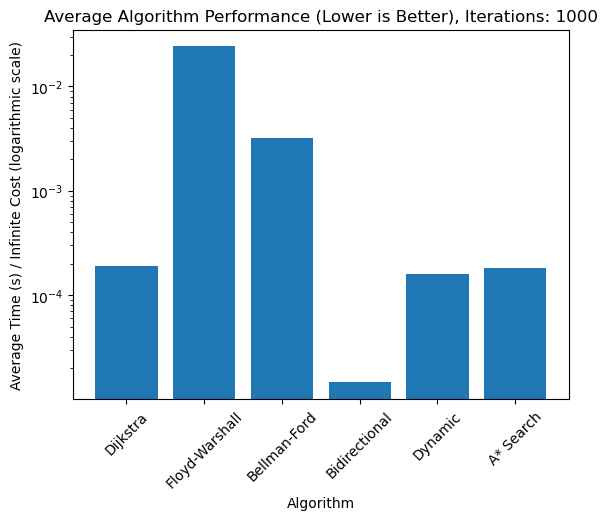

In [11]:
# Choose the best algorithm based on performance
best_algorithm, best_path = choose_best_algorithm(algorithm_performance)

# Display the best algorithm's path
print(f"Best path found by {best_algorithm}: {best_path}")

# Plot the average performance
average_performance = {
    algo: sum(duration for duration, _ in times) / len(times)
    for algo, times in algorithm_performance.items()
}
plt.bar(average_performance.keys(), average_performance.values())
plt.title(f"Average Algorithm Performance (Lower is Better), Iterations: {iterations}")
plt.yscale('log')
plt.xlabel("Algorithm")
plt.ylabel("Average Time (s) / Infinite Cost (logarithmic scale)")
plt.xticks(rotation=45)
plt.show()

### Conclusion